# Exploratory Data Analysis (EDA)

This notebook performs exploratory data analysis (EDA) on the dataset, visualizing distributions, correlations, and other key insights.

In [ ]:
# ! pip install seaborn

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

## Load the dataset

In [69]:
#df = pd.read_csv('B2W-Reviews01.csv', sep=';', quotechar='"')
#df = pd.read_csv('B2W-Reviews01.csv', sep=',', quotechar='"', encoding='utf-8')
df = pd.read_csv('B2W-Reviews01.csv', sep=',', quotechar='"', encoding='utf-8', dtype={'product_id': str}, low_memory=False)

## Basic information about the dataset

In [87]:
print(f"Dataset shape: {df.shape}")
print(f"Number of unique products: {df['product_id'].nunique()}")
print(f"Number of unique reviewers: {df['reviewer_id'].nunique()}")

Dataset shape: (132373, 18)
Number of unique products: 48001
Number of unique reviewers: 112993


## Check column names and data types

In [88]:
print("\nColumn names and data types:")
print(df.dtypes)


Column names and data types:
submission_date           object
reviewer_id               object
product_id                object
product_name              object
product_brand             object
site_category_lv1         object
site_category_lv2         object
review_title              object
overall_rating             int64
recommend_to_a_friend     object
review_text               object
reviewer_birth_year      float64
reviewer_gender           object
reviewer_state            object
processed_tokens          object
sentiment_binary          object
sentiment_3class          object
recommendation            object
dtype: object


## Check for missing values

In [89]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
submission_date              0
reviewer_id                  0
product_id                   0
product_name                84
product_brand            91391
site_category_lv1            6
site_category_lv2         4013
review_title               302
overall_rating               0
recommend_to_a_friend       18
review_text               3275
reviewer_birth_year       5984
reviewer_gender           4136
reviewer_state            3991
processed_tokens             0
sentiment_binary             0
sentiment_3class             0
recommendation              18
dtype: int64


## Basic statistics of ratings

In [90]:
print("\nBasic statistics of ratings:")
print(df['overall_rating'].describe())


Basic statistics of ratings:
count    132373.000000
mean          3.492004
std           1.530289
min           1.000000
25%           2.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: overall_rating, dtype: float64


## Distribution of ratings

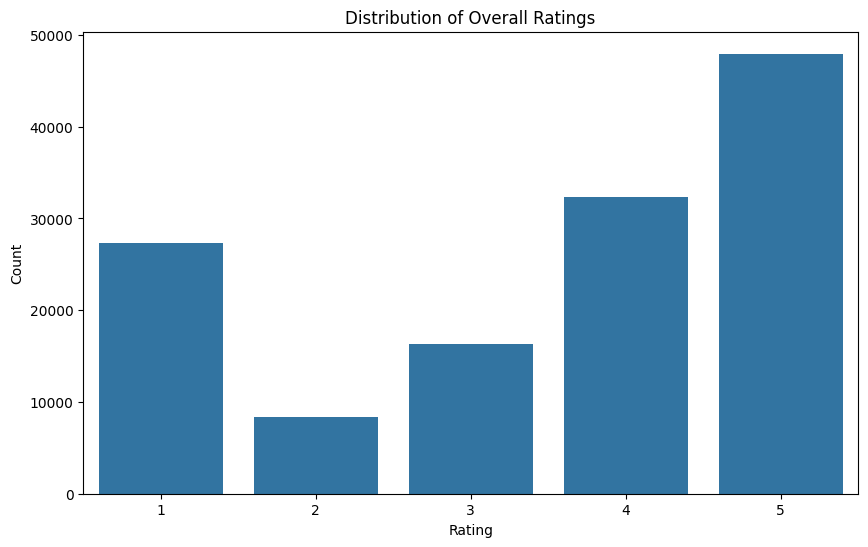

In [91]:
plt.figure(figsize=(10, 6))
sns.countplot(x='overall_rating', data=df)
plt.title('Distribution of Overall Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('rating_distribution.png')

## Distribution of "recommend to a friend"

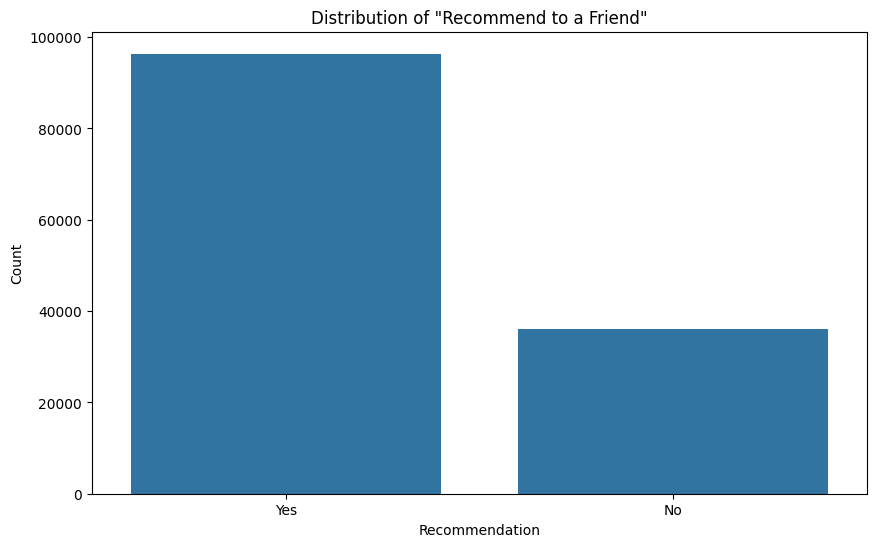

In [92]:
plt.figure(figsize=(10, 6))
sns.countplot(x='recommend_to_a_friend', data=df)
plt.title('Distribution of "Recommend to a Friend"')
plt.xlabel('Recommendation')
plt.ylabel('Count')
plt.savefig('recommendation_distribution.png')

## Cross-tabulation of rating vs recommendation

In [93]:
rating_vs_recommendation = pd.crosstab(df['overall_rating'], df['recommend_to_a_friend'])
print("\nRating vs Recommendation:")
print(rating_vs_recommendation)


Rating vs Recommendation:
recommend_to_a_friend     No    Yes
overall_rating                     
1                      26574    795
2                       6321   2068
3                       1879  14434
4                        508  31837
5                        705  47234


## Percentage of recommendations per rating

In [94]:
rating_vs_recommendation_pct = pd.crosstab(
    df['overall_rating'], df['recommend_to_a_friend'], 
    normalize='index'
).round(2) * 100
print("\nPercentage of recommendations per rating:")
print(rating_vs_recommendation_pct)


Percentage of recommendations per rating:
recommend_to_a_friend    No   Yes
overall_rating                   
1                      97.0   3.0
2                      75.0  25.0
3                      12.0  88.0
4                       2.0  98.0
5                       1.0  99.0


## Distribution of products by category

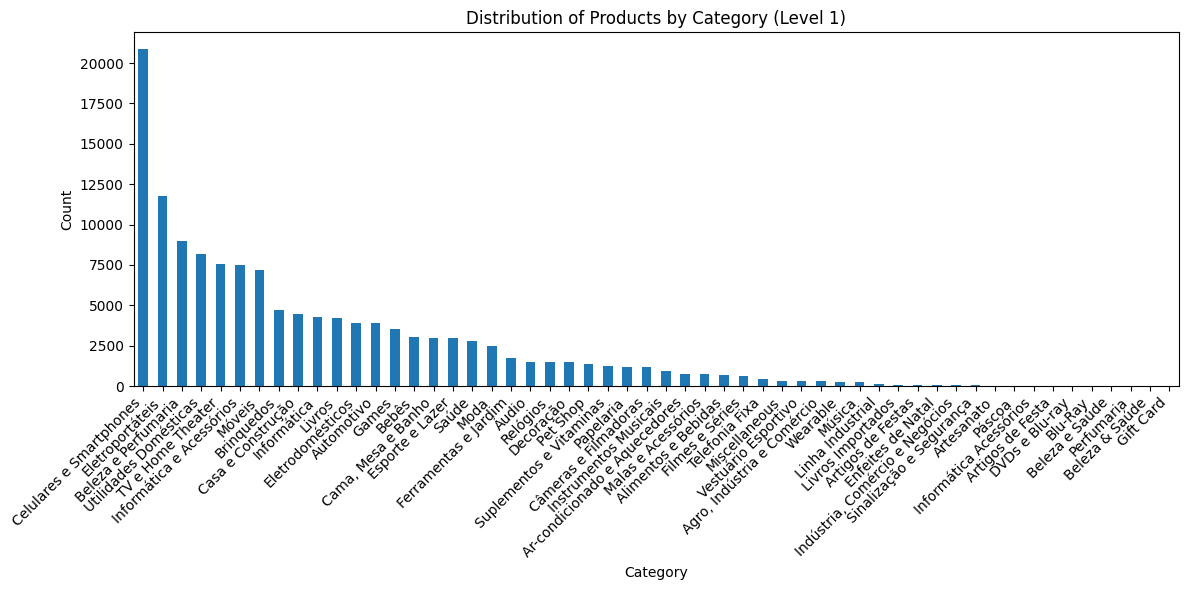

In [95]:
plt.figure(figsize=(12, 6))
df['site_category_lv1'].value_counts().plot(kind='bar')
plt.title('Distribution of Products by Category (Level 1)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('category_distribution.png')

## Distribution of reviews by reviewer gender

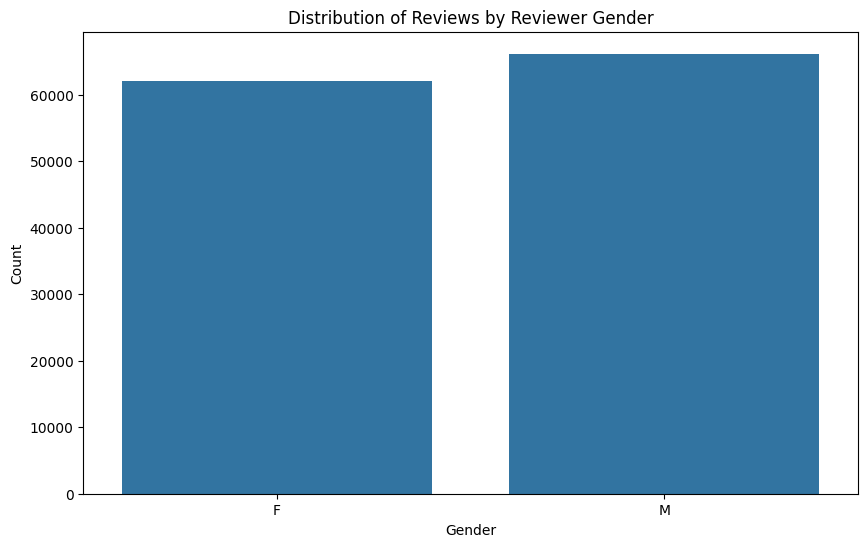

In [96]:
plt.figure(figsize=(10, 6))
sns.countplot(x='reviewer_gender', data=df)
plt.title('Distribution of Reviews by Reviewer Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.savefig('gender_distribution.png')

## Distribution of reviews by reviewer state

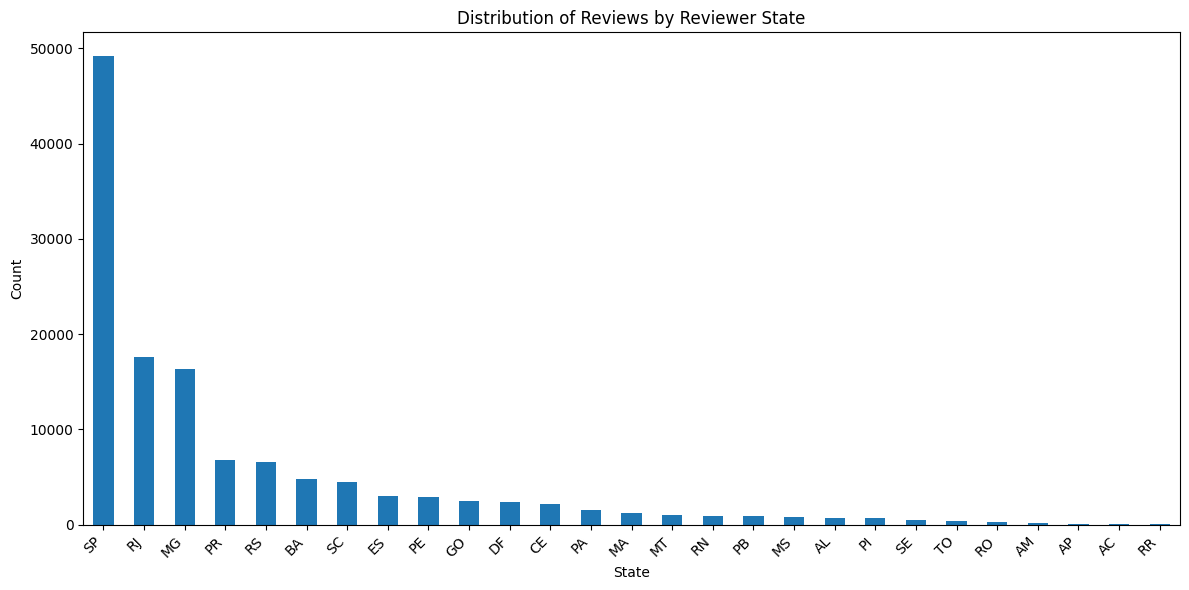

In [97]:
plt.figure(figsize=(12, 6))
df['reviewer_state'].value_counts().plot(kind='bar')
plt.title('Distribution of Reviews by Reviewer State')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('state_distribution.png')

## Review text length statistics

In [98]:
#df['review_length'] = df['review_text'].apply(len)
#df['review_word_count'] = df['review_text'].apply(lambda x: len(str(x).split()))

df['review_length'] = df['review_text'].fillna("").apply(len)
df['review_word_count'] = df['review_text'].fillna("").apply(lambda x: len(str(x).split()))


print("\nReview text length statistics:")
print(df[['review_length', 'review_word_count']].describe())


Review text length statistics:
       review_length  review_word_count
count  132373.000000      132373.000000
mean      133.362959          22.453068
std       126.586408          22.167414
min         0.000000           0.000000
25%        66.000000          11.000000
50%        93.000000          16.000000
75%       153.000000          26.000000
max      4548.000000         795.000000


## Plot distribution of review lengths

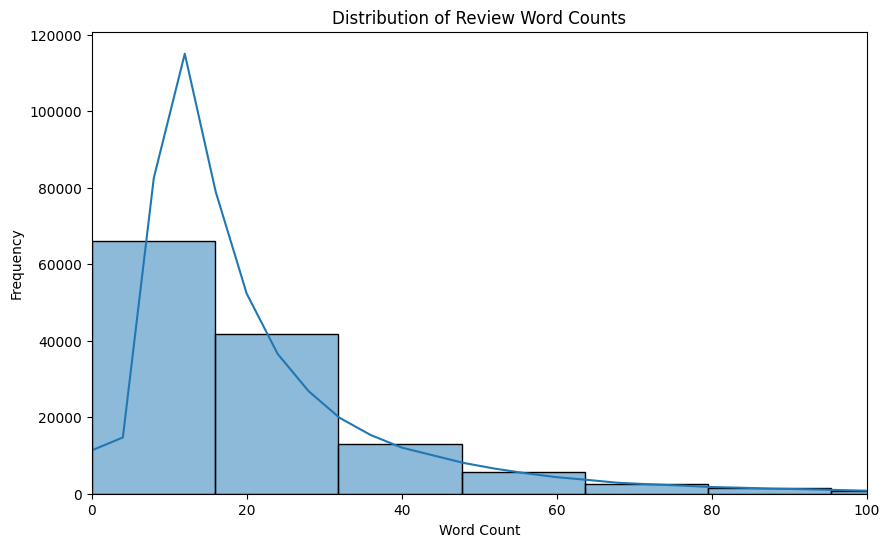

In [99]:
plt.figure(figsize=(10, 6))
sns.histplot(df['review_word_count'], bins=50, kde=True)
plt.title('Distribution of Review Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.xlim(0, 100) # Limiting to 100 words for better visualization
plt.savefig('review_length_distribution.png')

## Analysis of most common words

## First, download stopwords if not already

In [70]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nuno_Moreira\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nuno_Moreira\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Function to preprocess text

In [71]:
def preprocess_text(text):
    if not isinstance(text, str):
        return []
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords (Portuguese)
    stop_words = set(stopwords.words('portuguese'))
    tokens = [word for word in tokens if word not in stop_words]
    
    return tokens

## Apply preprocessing to review text

In [72]:
df['processed_tokens'] = df['review_text'].apply(preprocess_text)

## Count word frequencies

In [73]:
all_words = []
for tokens in df['processed_tokens']:
    all_words.extend(tokens)

word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)

print("\nMost common words:")
for word, count in most_common_words:
    print(f"{word}: {count}")


Most common words:
produto: 70212
bom: 25140
recomendo: 23813
entrega: 22614
bem: 16834
qualidade: 16313
chegou: 15938
prazo: 15595
excelente: 14277
antes: 12405
comprei: 11642
ótimo: 11500
gostei: 10485
super: 10475
americanas: 10245
boa: 9253
pra: 8957
recebi: 8924
veio: 8871
ainda: 8589


## Plot most common words

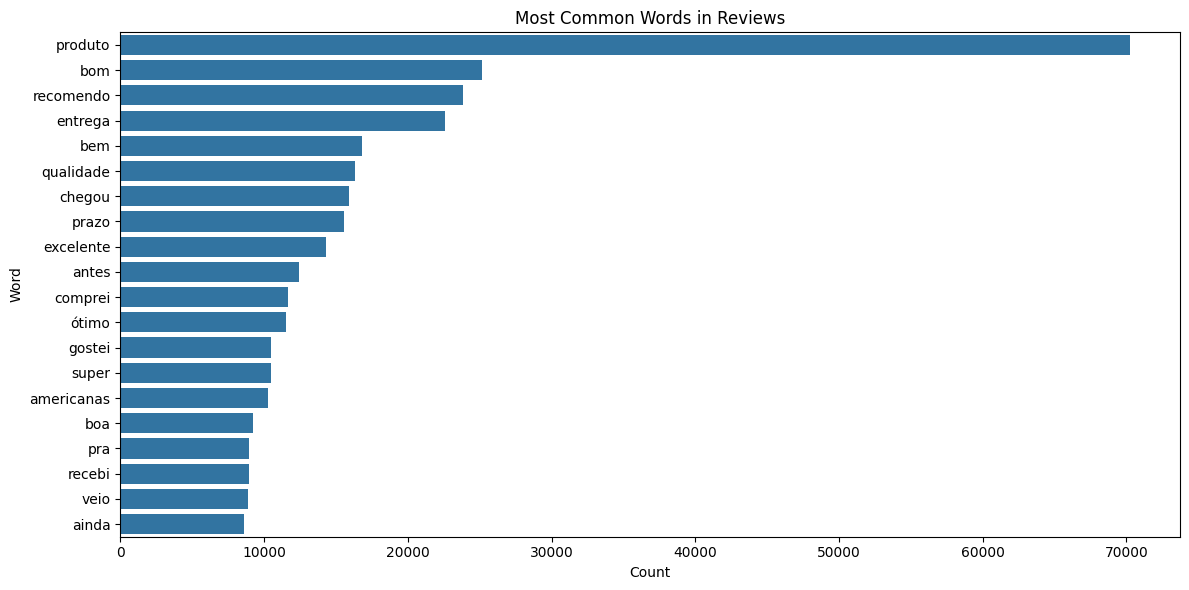

In [74]:
plt.figure(figsize=(12, 6))
words, counts = zip(*most_common_words)
sns.barplot(x=list(counts), y=list(words))
plt.title('Most Common Words in Reviews')
plt.xlabel('Count')
plt.ylabel('Word')
plt.tight_layout()
plt.savefig('common_words.png')

## TF-IDF analysis

In [75]:
#tfidf_vectorizer = TfidfVectorizer(max_features=1000, preprocessor=lambda x: ' '.join(preprocess_text(x)))
#tfidf_matrix = tfidf_vectorizer.fit_transform(df['review_text'])

# First, check for NaN values in the review_text column
print(f"Number of NaN values in review_text: {df['review_text'].isna().sum()}")

# Option 1: Remove rows with NaN values in review_text
df_clean = df.dropna(subset=['review_text'])
print(f"Rows before cleaning: {len(df)}, Rows after cleaning: {len(df_clean)}")

# Option 2: Fill NaN values with an empty string (if you don't want to drop rows)
# df['review_text'] = df['review_text'].fillna('')

# Now try the TF-IDF vectorization again on the cleaned data
tfidf_vectorizer = TfidfVectorizer(max_features=1000, preprocessor=lambda x: ' '.join(preprocess_text(x)))
tfidf_matrix = tfidf_vectorizer.fit_transform(df_clean['review_text'])  # Use df_clean instead of df

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

Number of NaN values in review_text: 3275
Rows before cleaning: 132373, Rows after cleaning: 129098
TF-IDF matrix shape: (129098, 1000)


## Get feature names and TF-IDF scores

In [76]:
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.sum(axis=0).A1

## Create a DataFrame for better visualization

In [77]:
tfidf_df = pd.DataFrame({'word': feature_names, 'tfidf': tfidf_scores})
tfidf_df = tfidf_df.sort_values('tfidf', ascending=False).head(20)

print("\nTop 20 words by TF-IDF score:")
print(tfidf_df)


Top 20 words by TF-IDF score:
           word        tfidf
756     produto  9247.965750
124         bom  5400.046300
806   recomendo  5272.333307
343     entrega  4726.969543
772   qualidade  3974.820865
378   excelente  3845.927093
733       prazo  3790.959689
173      chegou  3653.125934
116         bem  3550.602647
63        antes  3199.066656
994       ótimo  3113.513536
458      gostei  3000.621530
882       super  2783.497700
121         boa  2405.666222
205     comprei  2203.504525
828      rápida  2193.735609
798      recebi  2075.498573
56   americanas  2009.824551
958        veio  1974.974579
992       ótima  1937.395621


## Plot TF-IDF scores

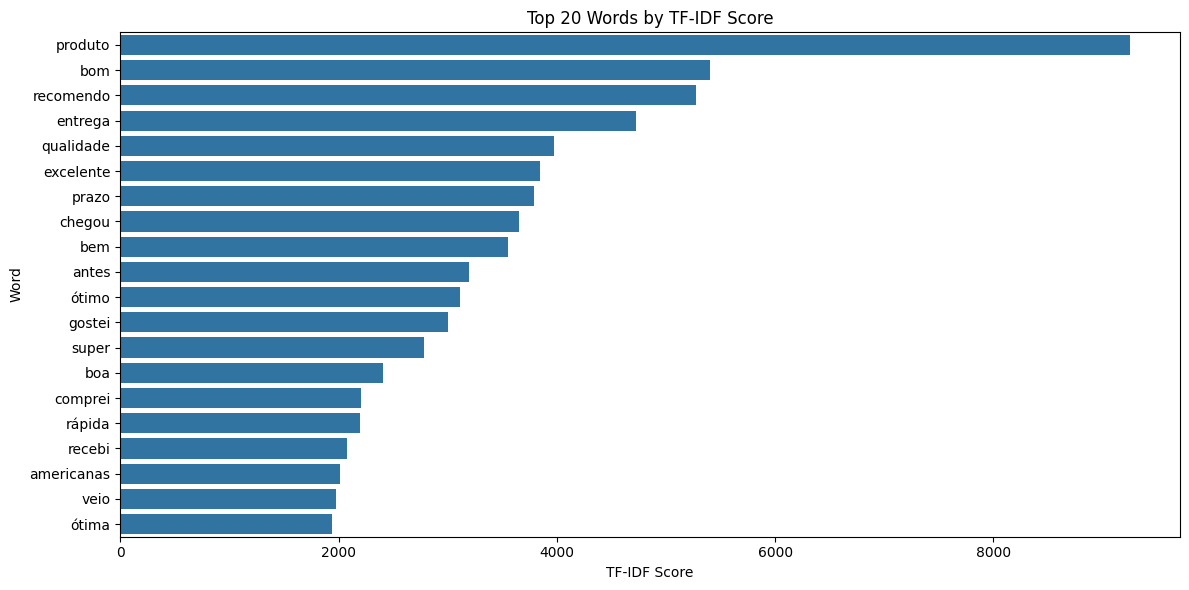

In [78]:
plt.figure(figsize=(12, 6))
sns.barplot(x='tfidf', y='word', data=tfidf_df)
plt.title('Top 20 Words by TF-IDF Score')
plt.xlabel('TF-IDF Score')
plt.ylabel('Word')
plt.tight_layout()
plt.savefig('tfidf_scores.png')

## Analysis of ratings by category

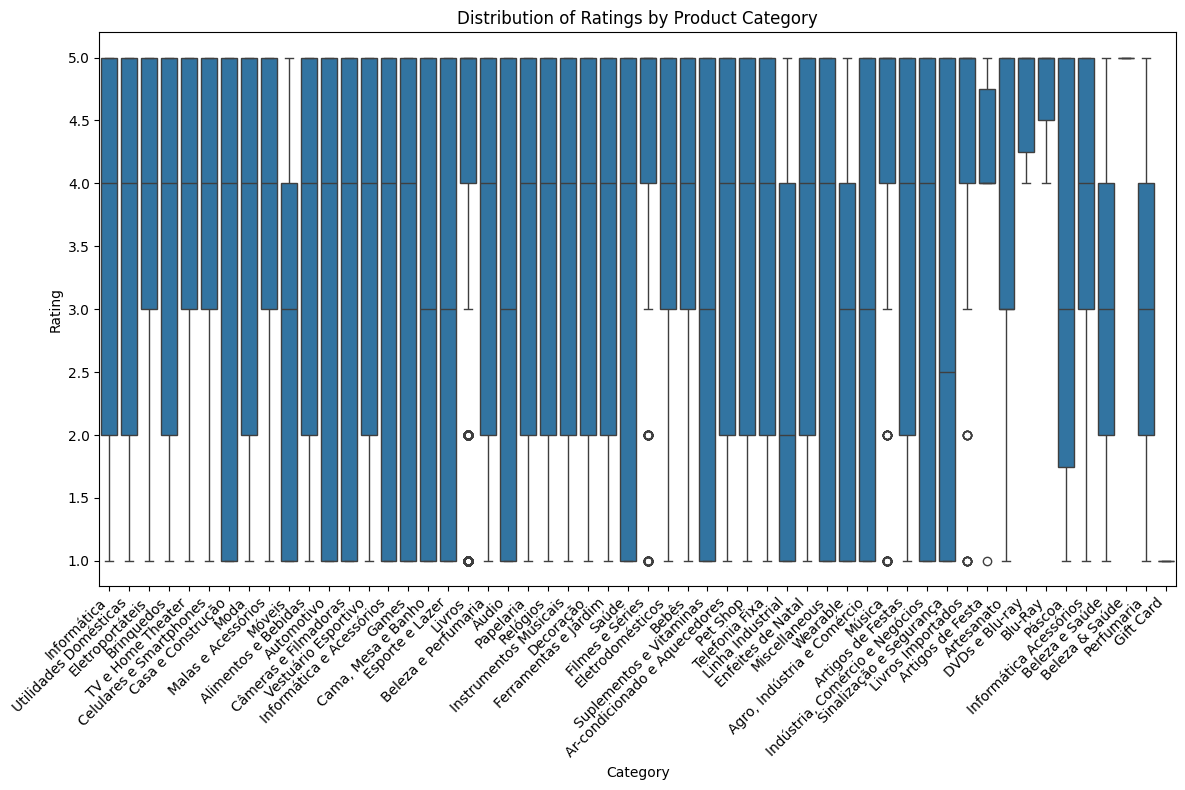

In [79]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='site_category_lv1', y='overall_rating', data=df)
plt.title('Distribution of Ratings by Product Category')
plt.xlabel('Category')
plt.ylabel('Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('ratings_by_category.png')

## Analysis of ratings by reviewer gender

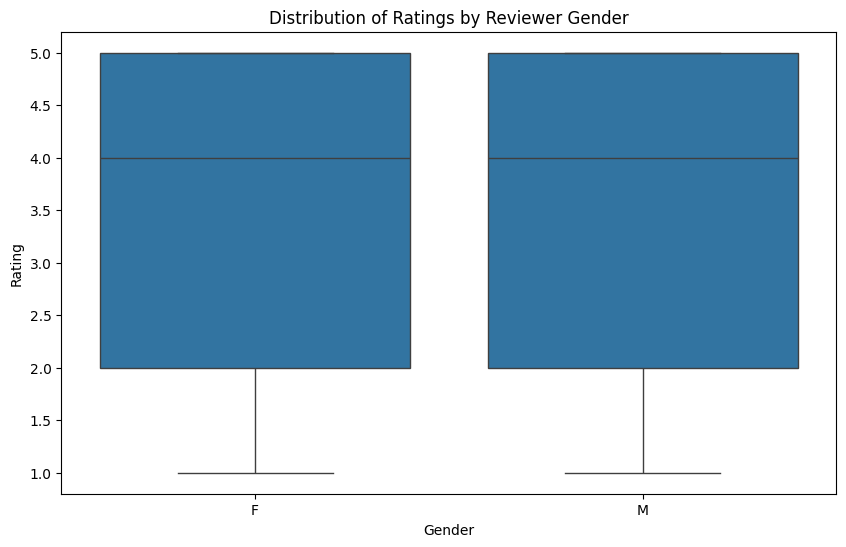

In [80]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='reviewer_gender', y='overall_rating', data=df)
plt.title('Distribution of Ratings by Reviewer Gender')
plt.xlabel('Gender')
plt.ylabel('Rating')
plt.savefig('ratings_by_gender.png')

## Define target variables for classification tasks

## 1. Binary sentiment (positive vs negative)

In [81]:
df['sentiment_binary'] = df['overall_rating'].apply(lambda x: 'positive' if x >= 4 else 'negative')

## 2. Three-class sentiment (positive, neutral, negative)

In [82]:
df['sentiment_3class'] = df['overall_rating'].apply(
    lambda x: 'positive' if x >= 4 else ('neutral' if x == 3 else 'negative')
)

## 3. Recommendation (yes/no)

In [83]:
df['recommendation'] = df['recommend_to_a_friend']

## Distribution of binary sentiment

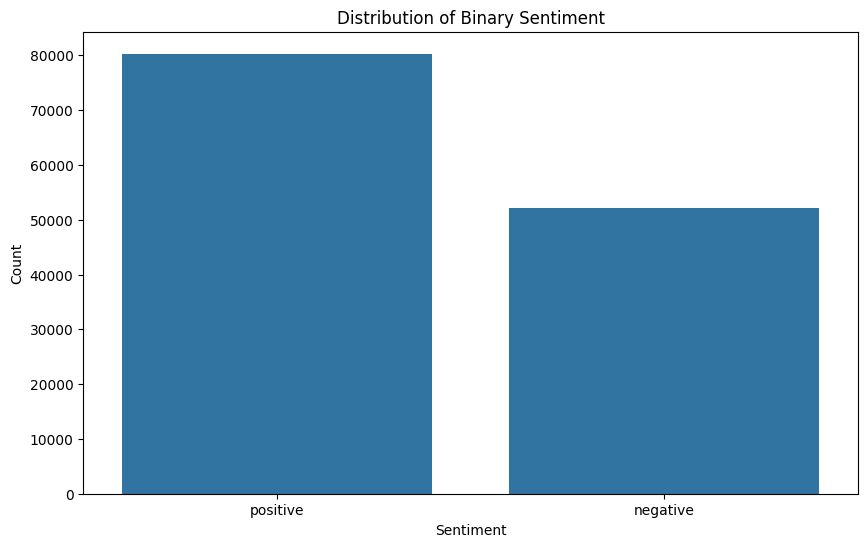

In [84]:
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment_binary', data=df)
plt.title('Distribution of Binary Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.savefig('binary_sentiment_distribution.png')

## Distribution of three-class sentiment

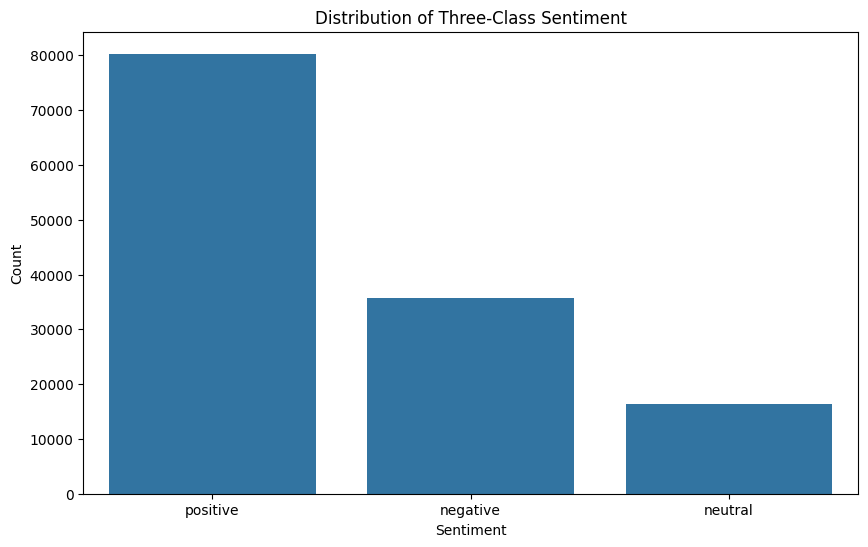

In [85]:
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment_3class', data=df)
plt.title('Distribution of Three-Class Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.savefig('3class_sentiment_distribution.png')

## Save the processed dataframe for further analysis

In [100]:
df.to_csv('b2w_reviews_processed.csv', index=False)

print("\nExploratory data analysis completed. Visualizations saved.")


Exploratory data analysis completed. Visualizations saved.
